# Adding TensorBoard to apparatus-2

## Objectives
1. Add TensorBoard visualization to apparatus-2.
2. Switch over to the `bigcluster_raw` dataset, which lacks the third column of 1s (that's a trick for doing more with matrix multiplication, but it shouldn't pollute the dataset).  This will leave us better positioned to move on to apparatus-4 where we'll switch to a partitioned dataset.

From apparatus-2 we inherit the following:
- Logistic Regression with 
- Pausable/reloadable sessions using `tf.train.Supervisor.managed_session()`
- High-volume CSV Input Pipeline.

Coming Up Next...
- Partitioned dataset (train, validation, test)
- Early-stopping regularization
- Purging of tf.train.Supervisor ...which is already deprecated, dammit!  I *just* learned how to use that!  Now I'll have to learn MonitoredSessions instead.  For apparatus-4, however, I'll stick with the basics like Chip Huyen does:
    - tf.Session
    - tf.train.write_graph()
    - tf.summary.FileWriter
    - tf.train.Saver

## The Input Pipeline

Note: Don't run this notebook until you've run *generate_data.ipynb* at least once first to create the directory of data files.

In [1]:
import os
import tensorflow as tf
notebook_dir = 'bigcluster_parted/train'
g = tf.Graph()

### Mini-batch Design Matrix

Get the list of .csv files in the `notebook_dir`.

In [2]:
csv_file_list = [os.path.join(notebook_dir, x) for x in os.listdir(notebook_dir) if x.endswith('.csv')]
# csv_file_list

['bigcluster_parted/train/61.csv',
 'bigcluster_parted/train/79.csv',
 'bigcluster_parted/train/68.csv',
 'bigcluster_parted/train/24.csv',
 'bigcluster_parted/train/41.csv',
 'bigcluster_parted/train/77.csv',
 'bigcluster_parted/train/40.csv',
 'bigcluster_parted/train/5.csv',
 'bigcluster_parted/train/22.csv',
 'bigcluster_parted/train/15.csv',
 'bigcluster_parted/train/63.csv',
 'bigcluster_parted/train/45.csv',
 'bigcluster_parted/train/43.csv',
 'bigcluster_parted/train/57.csv',
 'bigcluster_parted/train/1.csv',
 'bigcluster_parted/train/46.csv',
 'bigcluster_parted/train/51.csv',
 'bigcluster_parted/train/70.csv',
 'bigcluster_parted/train/44.csv',
 'bigcluster_parted/train/38.csv',
 'bigcluster_parted/train/59.csv',
 'bigcluster_parted/train/23.csv',
 'bigcluster_parted/train/84.csv',
 'bigcluster_parted/train/7.csv',
 'bigcluster_parted/train/4.csv',
 'bigcluster_parted/train/81.csv',
 'bigcluster_parted/train/47.csv',
 'bigcluster_parted/train/17.csv',
 'bigcluster_parted/trai

Add operations to the graph which prepare mini-batches.

In [3]:
BATCH_SIZE = 16

with g.as_default():
    # Create a queue of the filenames
    filename_queue = tf.train.string_input_producer(csv_file_list)
    
    # (if there are lines of metadata at the top of the file, we can skip them using this parameter)
    reader = tf.TextLineReader(skip_header_lines=0)
    
    # Create graph operations to read a line from a CSV file (key is optional, but yields good info)
    key, line_from_file = reader.read(filename_queue)
    
    # Specify the default field values (in case they're missing) and their type
    record_defaults = [[0.5], [0.5], [tf.to_int32(0)]]
    
    # Parse the CSV string into an example tensor (x,y,w,label)
    example = tf.decode_csv(line_from_file, record_defaults=record_defaults)
    
    # Split the example into a feature vector and a label.
    # Add the extra 1 so we can apply bias via matrix multiplication (this extra 1 used to be right in the CSV file)
    features = example[:2] + [1.0]
    label = example[-1]
    
    # Graph operations that produce a mini-batch (key batch is optional)
    key_batch, data_batch, label_batch = tf.train.shuffle_batch(
        [key, features, label], 
        batch_size=BATCH_SIZE, 
        capacity=400, 
        min_after_dequeue=100)

There is a lot going on in this block and the documentation for these functions isn't totally clear, but if you play with the parameters of `tf.train.shuffle_batch` and watch that `key` variable, it quickly becomes apparent what's going on:
- Producer threads continually read examples from the files and dump them into a bin (a random queue) unless the bin contains `capacity` examples (in which case they wait until it doesn't).
- Consumer threads remove randomly selected `batch_sized` examples from the bin unless it contains < `batch_size + min_after_dequeue` examples.
- You can make mini-batches indefinitely (the data are re-read).
- Each time `tf.train.shuffle_batch` is called a file is randomly chosen and examples are read from it **in sequence**, starting from the first.
- If the same file is opened multiple times, the reader doesn't pick up where it left off: it reads from the beginning again!  (So, make sure `batch_size + min_after_dequeue` $\geq$ #examples/file)

Particularly useful tests:
- If you set `min_after_dequeue=0` then each mini-batch contains the first `batch_size` examples in order (because we gave `shuffle_batch` permission to empty the queue without waiting for more than one example).  This means we have to set `min_after_dequeue` $\geq$ number of examples in each file (otherwise the examples at the end of each file will never appear in a mini-batch).
- If you set `min_after_dequeue=1` then two examples are tossed in the bin and one of them is drawn at random and replaced by the next example in the file.  Then we choose another one at random.

**Question:** Could I use `reader.read_up_to()` instead of `reader.read()` here?

#### Quick check that the extra 1 is added properly

In [4]:
# with tf.Session(graph=g) as s:
#     s.run(tf.global_variables_initializer())
#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(coord=coord, sess=s)
    
#     print(s.run([example, features]))

#     coord.request_stop()
#     coord.join(threads)

## Logistic Regression

See `apparatus-2.ipynb` for discussion of the math behind logistic regression with stochastic gradient descent.

### Trainable Parameters: $\boldsymbol \theta = (\theta_0, \theta_1, \theta_2) \in \mathbb R^3$

In [5]:
with g.as_default():
    theta = tf.get_variable(name="theta", 
                            shape=[3], 
                            initializer=tf.random_normal_initializer(mean=0, stddev=1, seed=None, dtype=tf.float32),
                            dtype=tf.float32)
    print(theta)

<tf.Variable 'theta:0' shape=(3,) dtype=float32_ref>


Let's do a quick check to make sure theta looks right when it's initialized.  If you get all zeroes, check the console for error messages.  Sometimes it fails to allocate GPU memory for whatever reason. 

In [6]:
with tf.Session(graph=g) as s:
    tf.global_variables_initializer().run()  # Necessary?  Yes!  This is how theta gets initialized
    print(s.run([theta]))

[array([-1.42032802, -0.19118559,  1.41559148], dtype=float32)]


### Training Operation

As mentioned earlier, despite the fact that 
$$
H(y,h_{\boldsymbol \theta} (\mathbf p)) = (y-1) \log (1-h_{\boldsymbol \theta} (\mathbf p)) - y \log h_{\boldsymbol \theta} (\mathbf p)
$$
we're better off mashing the application of the sigmoid together with the cross-entropy calculution (using `tf.nn.sigmoid_cross_entropy_with_logits`) instead of doing those one at a time.  Then we compute the gradient of the loss after that using the `tf.train.GradientDescentOptimizer`.

In [7]:
learning_rate = 0.01
with g.as_default():
    # Step counter
    global_step = tf.Variable(0, name="global_step", trainable=False)

    # Compute the hidden layer output (pre-sigmoid function)
    logits = tf.reshape(tf.matmul(data_batch, theta[:,None]), [-1])
    
    # Compute the loss of each example in the mini-batch
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(label_batch, tf.float32), logits=logits)
    
    # Find the mean loss of the mini-batch
    loss = tf.reduce_mean(losses)
    
    # Train Op
    train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss, global_step=global_step)

### TensorBoard Summaries (NEW!)

In [8]:
with g.as_default():
    with tf.name_scope("summaries"):
        tf.summary.scalar("loss", loss)
        tf.summary.histogram("histogram_loss", loss)
        summary_op = tf.summary.merge_all()

Just for a sanity check, let's run our train_op in an old-fashioned tf.Session.  For the real training, we'll use a tf.train.Supervisor.managed_session() 

In [9]:
# with tf.Session(graph=g) as s:
#     s.run(tf.global_variables_initializer())
#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(coord=coord, sess=s)
    
#     for i in range(500):
#         t_op, ls, gstep = s.run([train_op, loss, global_step])
#         if (i % 100 == 0):
#             print("step %3d:\tloss = %f" % (gstep, ls))

#     coord.request_stop()
#     coord.join(threads)

Looks good.  Now let's do it with a pausable session.

### Training Session

Our queue runners will be sampling stochastically with replacement from the whole pool of input data for each batch.  That means--unlike a scheme in which all the training data is permuted--we don't have proper epochs.  What we'll do instead is measure the size of the pool and take an "epoch" to be simply that many examples (even if some examples are missed while others are sampled more than once during an "epoch" of training).

In [10]:
import subprocess
import numpy as np
csv_list_str = " ".join(csv_file_list)  # input filenames as a space-delimited list
training_pool_size = int(subprocess.check_output("cat " + csv_list_str + " | wc -l", shell=True).decode('UTF-8'))
batches_per_epoch = int(np.ceil(training_pool_size / BATCH_SIZE))

TensorFlow supports saving and loading the network parameters using the `tf.train.Saver` class. Since we want checkpoints, however, we can make this easier by using a `tf.train.Supervisor.managed_session` instead of the usual `tf.Session`.  

A `managed_session` has its own Saver and it will save checkpoints automatically and reload from them.  The only thing it leaves for us to do is to implement is the "pause button."  To do that, we'll periodically check the training directory for a file named "pause".  If one exists, we'll delete it (in preparation for the next use), save a checkpoint manually, and then shut down the training.

**BEFORE RUNNING THE NEXT CELL**:
- run `tensorboard --logdir ./apparatus-3 &` in a bash terminal
- Have this command ready to go:
```
touch ./apparatus-3/pause
```

**NB**: Only the *values* of the network parameters are saved and reloaded--not the network topology itself.  We still have to build the graph and if there's input (which there usually is), load it.  The step we skip is the network initialization step (`tf.global_variables_initializer().run()`).  Obviously, we have to leave that to `managed_session()` since we want it to handle the task of choosing whether to reload values from storage or initialize them from scratch.

In [11]:
import time
NOTEBOOK_DIR = "apparatus-3"
pause_file = os.path.join(NOTEBOOK_DIR, "pause")
checkpoint_file = os.path.join(NOTEBOOK_DIR, "model.ckpt")
status_report_freq = 1  # number of seconds training status updates 

# Save the "metagraph" (or, as TensorFlow calls it, the "graph")
#tf.train.write_graph(graph_or_graph_def=g, logdir=training_dir, name="apparatus-3_graph.pb", as_text=False)

g.add_to_collection('theta', theta)
sv = tf.train.Supervisor(logdir=NOTEBOOK_DIR, graph=g, save_model_secs=0.01, 
                         save_summaries_secs=0.01,        # NEW
                         summary_op=summary_op)           # NEW
with sv.managed_session() as s:

    # Supervisor calls tf.global_variables_initializer().run() for us
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord, sess=s)

    last_report_time = time.time()
    while not sv.should_stop():
        for i in range(batches_per_epoch):
            t_op, ls, gstep = s.run([train_op, loss, global_step])
        if (time.time() - last_report_time > status_report_freq):
            last_report_time = time.time()
            print("step %3d:\tloss = %f" % (gstep, ls))
            if (tf.gfile.Exists(pause_file)):
                sv.Stop()

    coord.request_stop()
    coord.join(threads)
    
    if tf.gfile.Exists(pause_file):
        print("Pause command received.  Saving checkpoint and shutting down.")
        tf.gfile.Remove(pause_file)
        sv.saver.save(s, checkpoint_file, global_step=global_step)

INFO:tensorflow:Restoring parameters from apparatus-3/model.ckpt-3808
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
step 3846:	loss = 0.149515
step 3884:	loss = 0.258461
step 3922:	loss = 0.150245
step 3960:	loss = 0.220264
step 3998:	loss = 0.334208
step 4036:	loss = 0.211476
step 4074:	loss = 0.214949
step 4112:	loss = 0.248319
step 4150:	loss = 0.311004
step 4188:	loss = 0.257253
step 4226:	loss = 0.308611
step 4264:	loss = 0.185745
step 4302:	loss = 0.246334
step 4340:	loss = 0.230586
step 4378:	loss = 0.258973
step 4416:	loss = 0.330673
step 4454:	loss = 0.190231
step 4492:	loss = 0.201685
step 4568:	loss = 0.137758
step 4606:	loss = 0.330604
step 4644:	loss = 0.239877
step 4682:	lo

### Pick up where we left off
Note the last reported `step` in the previous cell and then run it again.  Observe that training has begun at `last step + 100`.  You can even reboot the computer and rerun the notebook.  It'll still resume where it left off (as long as the training directory isn't wiped). 

In [11]:
# Kill the kernel, forcing it to restart
import os
#os._exit(0)

## Training Analysis

Get a list of the save files available.

In [1]:
import os

NOTEBOOK_DIR = "apparatus-3"

# Grab the most recent metagraph file
metagraph_files = [os.path.join(NOTEBOOK_DIR, x) for x in os.listdir(NOTEBOOK_DIR) if x.endswith('.meta')]
metagraph_files.sort()
metagraph_file = metagraph_files[-1]

# Grab the most recent graph file
graph_file = os.path.splitext(metagraph_file)[0]

print(metagraph_file, graph_file)

apparatus-3/model.ckpt-5214.meta apparatus-3/model.ckpt-5214


### Plot the trained dividing line

It's nice to see the loss going down, but what does the $\theta$ line actually look like?  To access the last value of $\theta$, we need to retrieve it from a `managed_session` again.

In [2]:
import tensorflow as tf

with tf.Session() as s:
    new_saver = tf.train.import_meta_graph(metagraph_file)
    new_saver.restore(s, graph_file)
    theta = tf.get_collection('theta')
    np_theta = s.run(theta)
print(np_theta)

INFO:tensorflow:Restoring parameters from apparatus-3/model.ckpt-5214
[array([ 2.22522473,  2.12785983, -2.03168106], dtype=float32)]


TensorFlow has the value of $\theta$ wrapped in a tensor together with its metadata (the type).  The tuple we need is in that first element.

In [3]:
print(np_theta[0])

[ 2.22522473  2.12785983 -2.03168106]


How do those three components of $\theta$ describe the dividing line between classes?  Well, to classify a point $u$ we look at the sign of $$\langle u, \theta \rangle = u_0 \theta_0 + u_1 \theta_1 + \theta_2$$

When $u$ is right *on* the dividing line that inner product is 0.  To draw this line using `matplotlib`, we need two distinct points it intersects: two solutions of the following expression (in which we assume that $(\theta_0, \theta_1) \neq (0,0)$):
$$u_0 \theta_0 + u_1 \theta_1 = -\theta_2$$

If $\theta_1 = 0$ then the dividing line is $$\left\{\left(-\frac {\theta_2} {\theta_0}, y\right) : y\in\mathbb R\right\}$$
Otherwise, the dividing line is $$\left\{\left(x, -\frac {\theta_2 + x \, \theta_0} {\theta_1} \right) : x\in\mathbb R\right\}$$

In [4]:
# We'll take left border = -1, right border = 2, top border = 2, bottom border = -1
if np_theta[0][1] == 0:
    l0 = [-np_theta[0][2] / np_theta[0][0], -1]
    l1 = [-np_theta[0][2] / np_theta[0][0], 2]
else:
    l0 = [-1, -(np_theta[0][2] - np_theta[0][0]) / np_theta[0][1]]
    l1 = [2,  -(np_theta[0][2] + 2.0 * np_theta[0][0]) / np_theta[0][1]]

In [5]:
print(l0, l1)

[-1, 2.0005574] [2, -1.1367141626715664]


### Read in the CSV files

In [6]:
DATA_DIR = 'bigcluster_parted'
TEST_DIR = os.path.join(DATA_DIR, 'test')
csv_file_list = [os.path.join(TEST_DIR, x) for x in os.listdir(TEST_DIR) if x.endswith('.csv')]
csv_file_list

['bigcluster_parted/test/24.csv',
 'bigcluster_parted/test/5.csv',
 'bigcluster_parted/test/22.csv',
 'bigcluster_parted/test/15.csv',
 'bigcluster_parted/test/1.csv',
 'bigcluster_parted/test/23.csv',
 'bigcluster_parted/test/7.csv',
 'bigcluster_parted/test/4.csv',
 'bigcluster_parted/test/17.csv',
 'bigcluster_parted/test/3.csv',
 'bigcluster_parted/test/25.csv',
 'bigcluster_parted/test/27.csv',
 'bigcluster_parted/test/14.csv',
 'bigcluster_parted/test/16.csv',
 'bigcluster_parted/test/2.csv',
 'bigcluster_parted/test/8.csv',
 'bigcluster_parted/test/18.csv',
 'bigcluster_parted/test/21.csv',
 'bigcluster_parted/test/13.csv',
 'bigcluster_parted/test/6.csv',
 'bigcluster_parted/test/12.csv',
 'bigcluster_parted/test/10.csv',
 'bigcluster_parted/test/9.csv',
 'bigcluster_parted/test/0.csv',
 'bigcluster_parted/test/28.csv',
 'bigcluster_parted/test/19.csv',
 'bigcluster_parted/test/11.csv',
 'bigcluster_parted/test/26.csv',
 'bigcluster_parted/test/20.csv']

In [7]:
import numpy as np
rows = np.ones(shape=(0,3), dtype=np.float32)
for csvfile in csv_file_list:
    rows = np.append(rows, np.genfromtxt(csvfile, delimiter=','), axis=0)
points = rows[:,:2] 
labels = rows[:,2]

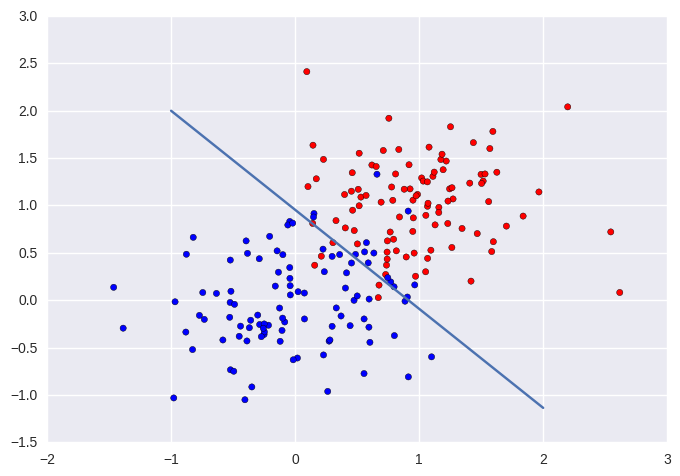

In [8]:
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

vec_colour = np.vectorize(lambda x: ['#0000FF','#FF0000'][int(x)])  # Transform the labels to colours
colour_labels = vec_colour(labels)
plt.scatter(points[:,0], points[:,1], c=colour_labels)
#plt.plot([-1,2], [2,-1])  # This is the line we want a classifier to find
plt.plot(l0, l1)
plt.show()

### Next Objectives
#### Early Stopping using a Validation dataset
- Choose a validation frequency $\omega$.  Every $\omega$ steps we'll evauluate the network on the validation set.
- Let $P \in \mathbb Z^+$ be our training "patience": the number of steps we're prepared to wait before seeing improvement in the validation error.
- Whenever the validation error drops, save the parameters.
- If the validation error goes more than $P$ steps without decreasing, we'll assume we've overtrained the network.  
- Stop training and restore the parameters from the step in which the network achieved the lowest error on the validation set.